<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_13_Autoencoders_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
# Import the libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

import copy

# PCA for model output
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

# Autoencoders for Occlusion

In [2]:
# Import the MNIST dataset coming with colab
data = np.loadtxt(open("sample_data/mnist_train_small.csv", "rb"), delimiter=",")

# remove the labesl
data = data[:,1:]

# Normalize on range 0-1
dataNorm = data/np.max(data)

# convert to tensor
dataT = torch.tensor(dataNorm).float()

## Implement Occlusion

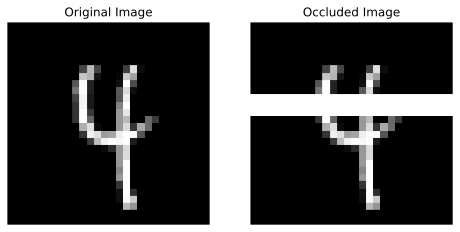

In [4]:
# Reconstruct a sample as an image
img = dataT[12345,:].view(28,28)

occluded = copy.deepcopy(img)
occluded[10:13,:] = 1

fig,ax = plt.subplots(1,2,figsize=(8,5))

ax[0].imshow(img,cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(occluded,cmap="gray")
ax[1].set_title("Occluded Image")
ax[1].axis("off")

plt.show()

## Train a Model

In [5]:
# Create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 128)

            # encoder layer
            self.enc = nn.Linear(128,50)

            # Latent Layer
            self.lat = nn.Linear(50,128)

            # Decoder Layer
            self.dec = nn.Linear(128,784)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.enc(x))
            x = F.relu(self.lat(x))
            y = torch.sigmoid(self.dec(x)) # data is normalized between 0-1, thus sigmoid
            return y

    # create model instance
    net = aenet()

    # Loss Function
    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [12]:
# Create a function to train the model
def function2trainTheModel():

    # Number of epochs: experimental time
    numepochs = 6

    # create new model instance
    net, lossfun, optimizer = createTheMNISTAE()

    losses = []

    # Batchsize and number of batches
    batchsize = 32
    numBatches = int(dataT.shape[0]/batchsize)

    # Loop over the epochs
    for epochi in range(numepochs):

        # get a permuted index vector
        randidx = np.random.permutation(dataT.shape[0]).astype(int)

        # Loop over the batches
        for batchi in range(numBatches):

            # Samples to use in this batch
            samps2use = range((batchi-1)*batchsize, batchi*batchsize)

            # Select those images
            X = dataT[randidx[samps2use],:]

            # Forward Pass and Loss
            yHat = net(X)
            # Loss is difference of the whole data matrix
            loss = lossfun(yHat,X)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

    # End of epochs loop

    # The final output
    return losses, net

Final loss: 0.0126


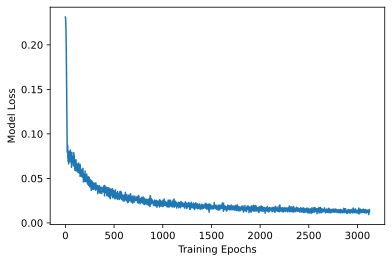

In [13]:
# Train the model
losses, net = function2trainTheModel()
print(f"Final loss: {losses[-1]:.4f}")

plt.plot(losses)
plt.xlabel("Training Epochs")
plt.ylabel("Model Loss")
plt.show()

### Add Occlusion to Some Images

In [31]:
# Pick a set of images
X = copy.deepcopy(dataT[:10,:])

# Add noise to them
for i in range(X.shape[0]):

    # Reshape the images
    img = X[i,:].view(28,28)

    # Occlude random rows or columns
    # Pick 21 pixcels from 0 to 9
    startloc = np.random.choice(range(10, 21))
    if i%2==0: #even -> horizontal occlusion
        img[startloc:startloc+1, :] = 1
    else:  # odd -> vertical occlusion
        img[:, startloc:startloc+1] = 1

# Run the images through the model
deOccluded = net(X)

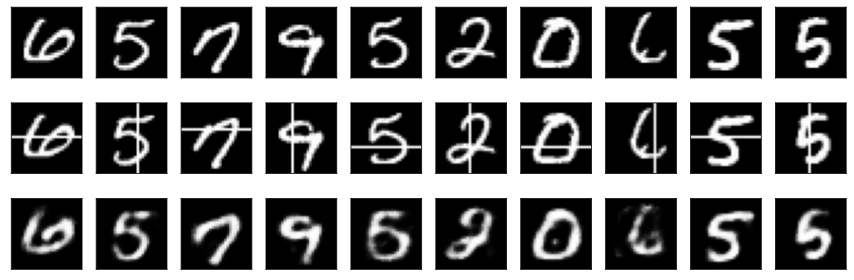

In [32]:
fig,axs = plt.subplots(3,10, figsize=(15,5))

for i in range(10):
    axs[0,i].imshow(dataT[i,:].view(28,28).detach(), cmap="gray")
    axs[1,i].imshow(X[i,:].view(28,28).detach(), cmap="gray")
    axs[2,i].imshow(deOccluded[i,:].view(28,28).detach(), cmap="gray")
    axs[0,i].set_xticks([]), axs[0,i].set_yticks([])
    axs[1,i].set_xticks([]), axs[1,i].set_yticks([])
    axs[2,i].set_xticks([]), axs[2,i].set_yticks([])

plt.show()

### Something More Quantitative

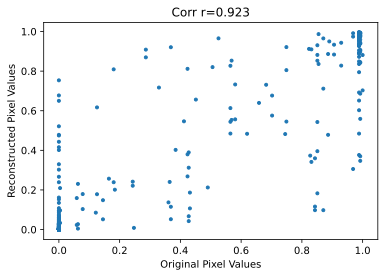

In [33]:
# We can quantify performance of de-oclusing be correlating it with original data
inOutCorr = np.corrcoef(dataT[9,:].detach(), deOccluded[9,:].detach())

plt.plot(dataT[9,:].detach(), deOccluded[9,:].detach(), ".")
plt.xlabel("Original Pixel Values")
plt.ylabel("Reconstructed Pixel Values")
plt.title(f"Corr r={inOutCorr[0,1]:.3f}")
plt.show()

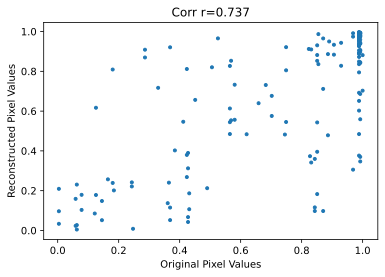

In [34]:
# Now try correlation by removing zero-valued pixcels

orig = dataT[9,:].detach()
recon = deOccluded[9,:].detach()

# Boolean vector that indicates pixcels > 0 (with some tolerance)
tol = 1e-04
nonZeroPixels = (orig>tol) & (recon>tol)

inOutCorr = np.corrcoef(orig[nonZeroPixels], recon[nonZeroPixels])

plt.plot(orig[nonZeroPixels], recon[nonZeroPixels], ".")
plt.xlabel("Original Pixel Values")
plt.ylabel("Reconstructed Pixel Values")
plt.title(f"Corr r={inOutCorr[0,1]:.3f}")
plt.show()

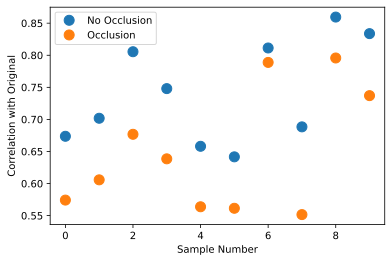

In [45]:
# Get the data with no occlusion
noOcclusion = net(dataT[:10,:])

# Now compare the deOccluded-original to noOccluded-original correlation
r = np.zeros((10,2))

for i in range(deOccluded.shape[0]):

    # Pixcel selection
    tol = 1e-04
    nonZeroPixels = (dataT[i,:]>tol) & (noOcclusion[i,:]>tol) & (deOccluded[i,:]>tol)

    # Correlations between groups
    r[i,0] = np.corrcoef(dataT[i,nonZeroPixels].detach(), noOcclusion[i,nonZeroPixels].detach())[0,1]
    r[i,1] = np.corrcoef(dataT[i,nonZeroPixels].detach(), deOccluded[i,nonZeroPixels].detach())[0,1]

# Plot
plt.plot(r, "o", markersize=10)
plt.legend(["No Occlusion", "Occlusion"])
plt.xlabel("Sample Number")
plt.ylabel("Correlation with Original")
plt.show()

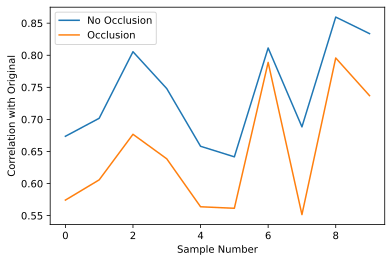

In [46]:
# Seen Better with line plot
plt.plot(r)
plt.legend(["No Occlusion", "Occlusion"])
plt.xlabel("Sample Number")
plt.ylabel("Correlation with Original")
plt.show()

# Tha Latent Space of AutoEncoder

In [48]:
# Will use the same MNIST data
# Create a class for the model
def createTheMNISTAE():

    class aenet(nn.Module):
        def __init__(self):
            super().__init__()

            # Input layer
            self.input = nn.Linear(784, 150)

            # encoder layer
            self.enc = nn.Linear(150,15)

            # Latent Layer
            self.lat = nn.Linear(15,150)

            # Decoder Layer
            self.dec = nn.Linear(150,784)

        # Forward Pass
        def forward(self,x):
            x = F.relu(self.input(x))

            # Do not override x: Output the hidden layer activation
            codex = F.relu(self.enc(x)) # This represents the latent layer

            x = F.relu(self.lat(codex))

            y = torch.sigmoid(self.dec(x)) # data is normalized between 0-1, thus sigmoid
            return y, codex

    # create model instance
    net = aenet()

    # Loss Function
    lossfun = nn.MSELoss()

    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer

In [49]:
# Test the model with a bit of data: Untrained model
net, lossfun, optimizer = createTheMNISTAE()

X = dataT[:5,:]
yHat = net(X)

print("Input Shape:")
print(X.shape)
print()

# yHat is a tuple with two variables: output and the latent space data
print(type(yHat), len(yHat))
print()

print("Shape of the Model Output")
print(yHat[0].shape)
print()

print("Shape of the Encoding Layer output")
print(yHat[1].shape)

Input Shape:
torch.Size([5, 784])

<class 'tuple'> 2

Shape of the Model Output
torch.Size([5, 784])

Shape of the Encoding Layer output
torch.Size([5, 15])


In [50]:
yHat

(tensor([[0.5012, 0.5114, 0.5026,  ..., 0.5014, 0.5005, 0.5102],
         [0.5014, 0.5131, 0.5020,  ..., 0.4987, 0.4999, 0.5068],
         [0.4990, 0.5137, 0.5037,  ..., 0.4960, 0.4979, 0.5077],
         [0.5034, 0.5115, 0.5006,  ..., 0.5019, 0.5009, 0.5062],
         [0.4997, 0.5143, 0.5026,  ..., 0.4978, 0.4995, 0.5093]],
        grad_fn=<SigmoidBackward0>),
 tensor([[0.1022, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0934,
          0.1169, 0.0000, 0.0265, 0.0333, 0.0000, 0.0000],
         [0.0530, 0.0000, 0.0000, 0.0000, 0.0000, 0.1000, 0.0828, 0.0000, 0.1274,
          0.0073, 0.0000, 0.0901, 0.0348, 0.0000, 0.0000],
         [0.0695, 0.0000, 0.0000, 0.0000, 0.0000, 0.0673, 0.0000, 0.0000, 0.0000,
          0.0737, 0.0000, 0.1308, 0.0576, 0.0000, 0.0000],
         [0.0157, 0.0220, 0.0000, 0.0000, 0.0000, 0.1551, 0.0258, 0.0000, 0.1603,
          0.0804, 0.0000, 0.0360, 0.0000, 0.0000, 0.0000],
         [0.0357, 0.0168, 0.0000, 0.0083, 0.0000, 0.0527, 0.0939, 0.0000,

In [51]:
def function2trainTheModel():

    # Number of epochs
    numepochs = 10000

    # create new model instance
    net, lossfun, optimizer = createTheMNISTAE()

    losses = torch.zeros(numepochs)

    # Loop over the epochs
    for epochi in range(numepochs):

        # Select a random set of images: This is sort of minibatches, but bootstrapped
        randomidx = np.random.choice(dataT.shape[0], size=32)
        X = dataT[randomidx,:]

        # Forward Pass and Loss: Remeber the cnages in class output
        yHat = net(X)[0]  # Caution: We only want the final model output
        # Loss is difference of the whole data matrix
        loss = lossfun(yHat,X)

        # BackProp
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Losses for each epoch
        losses[epochi] = loss.item()
    # End of epochs loop

    # The final output
    return losses, net

In [52]:
# Train the Model
losses, net = function2trainTheModel()
print(f"Final loss: {losses[-1]:.4f}")

Final loss: 0.0248


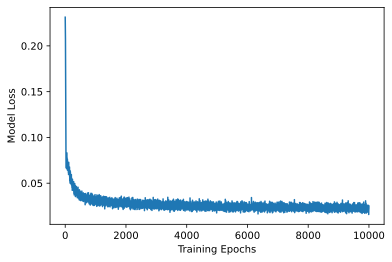

In [53]:
# Plot the results
plt.plot(losses)
plt.xlabel("Training Epochs")
plt.ylabel("Model Loss")
plt.show()

## Inspect the latent Space

In [54]:
# Use the entire dataset
yHat, latent = net(dataT)

# Print the sizes
print(yHat.shape)
print(latent.shape)

torch.Size([20000, 784])
torch.Size([20000, 15])


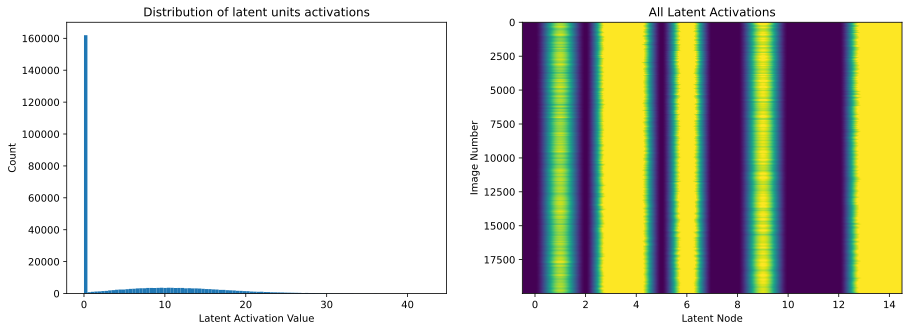

In [60]:
# Plot it
fig,ax = plt.subplots(1,2,figsize=(15,5))

ax[0].hist(latent.flatten().detach(), 100)
ax[0].set_xlabel("Latent Activation Value")
ax[0].set_ylabel("Count")
ax[0].set_title("Distribution of latent units activations")

ax[1].imshow(latent.detach(),aspect="auto",vmin=0, vmax=10)
ax[1].set_xlabel("Latent Node")
ax[1].set_ylabel("Image Number")
ax[1].set_title("All Latent Activations")

plt.show()